In [1]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, img_as_ubyte
from skimage.color import rgb2gray
import cv2

In [2]:
OBJECTS_FOUND = 0
COLOR_FOREGROUND = 0
COLOR_BACKGROUND = 255

def showimg(_img, _title="Obraz"):
    print(_img.shape, _img.dtype)
    plt.imshow(_img, cmap="gray")
    plt.axis('on')
    plt.suptitle(_title)
    plt.show()

(344, 549) uint8


C:\Users\Machina\Anaconda3\envs\py36\lib\site-packages\skimage\util\dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


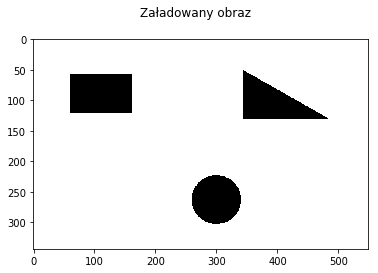

In [3]:
img = io.imread("./pattern1.png")
th = 128
img = img_as_ubyte(rgb2gray(img))
th, bim = cv2.threshold(img, thresh=th, maxval=255, type=cv2.THRESH_BINARY)
showimg(bim, _title="Załadowany obraz")

In [ ]:
def mark_object(_img, segtab, objnum=0, x=0, y=0):
    global COLOR_BACKGROUND
    if (x >= _img.shape[0]) or (x < 0) or (y >= _img.shape[1]) or (y < 0):
        return
    elif _img[x][y] == COLOR_BACKGROUND or segtab[x][y] >= 1:
        return
    segtab[x][y] = objnum
    mark_object(_img, segtab=segtab, objnum=objnum, x=x-1, y=y)  # gora
    mark_object(_img, segtab=segtab, objnum=objnum, x=x+1, y=y)  # dol
    mark_object(_img, segtab=segtab, objnum=objnum, x=x, y=y-1)  # lewo
    mark_object(_img, segtab=segtab, objnum=objnum, x=x, y=y+1)  # prawo

def segment_img(_img):
    obj_number = 1
    segment_table = np.zeros(_img.shape)
    for x in range(_img.shape[0]):
        for y in range(_img.shape[1]):
            if _img[x][y] == COLOR_BACKGROUND:
                continue
            else:
                mark_object(_img, segment_table, objnum=obj_number, x=x, y=y)
                OBJECTS_FOUND += 1
                obj_number += 1

segment_img(bim)
print(OBJECTS_FOUND)